In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import geopandas as gpd

# Reading Route file

we will add a column to indicate the route id as `ruta`. It will be the merge of `ruta`=`CoutryNum`+`StateNum`+Route`

In [2]:
# print(os.listdir('.'))
routes = pd.read_csv('./Routes.csv', encoding='ISO-8859-1')

routes['ruta'] = routes['CountryNum'].astype(str) + routes['StateNum'].astype(str) + routes['Route'].astype(str)

routes.head()

,CountryNum,StateNum,Route,RouteName,Active,Latitude,Longitude,Stratum,BCR,RouteTypeID,RouteTypeDetailID,ruta
0,840,2,1,ST FLORIAN,1,34.868688,-87.604142,14,27,1,1,84021
1,840,2,2,HILLSBORO,0,34.638675,-87.191292,14,24,1,1,84022
2,840,2,3,FLORENCE,0,34.800000,-87.733333,14,24,1,1,84023
3,840,2,4,TRADE,1,34.029788,-87.059235,13,28,1,1,84024
4,840,2,5,SUMMITT,0,34.201669,-86.493409,13,28,1,1,84025


## Reading abundance data from Stop files

In [3]:
def read_routes_BBS(directory_path):
    """
    Reads all CSV files starting with 'F' in a specified directory
    and combines them into a single large Pandas DataFrame.

    Args:
        directory_path (str): The path to the directory containing the CSV files.

    Returns:
        pandas.DataFrame: A single DataFrame containing data from all
                          matching CSV files, or an empty DataFrame if no
                          matching files are found or an error occurs.
    """
    # Construct the search pattern for CSV files starting with 'F'
    search_pattern = os.path.join(directory_path, 'F*.csv')
    
    # Find all files matching the pattern
    csv_files = glob.glob(search_pattern)

    # Check if any files were found
    if not csv_files:
        print(f"No CSV files starting with 'F' found in: {directory_path}")
        return pd.DataFrame() # Return an empty DataFrame

    # List to hold individual DataFrames
    dataframes = []

    print(f"Found {len(csv_files)} CSV files starting with 'F':")
    for file_path in csv_files:
        print(f"  - {os.path.basename(file_path)}")
        try:
            # Read each CSV file into a DataFrame
            df = pd.read_csv(file_path)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {os.path.basename(file_path)}: {e}")
            continue # Continue to the next file even if one fails

    # Concatenate all DataFrames into one large DataFrame
    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        return combined_df
    else:
        print("No DataFrames were successfully loaded.")
        return pd.DataFrame() # Return an empty DataFrame if no data was loaded


In [4]:
data = read_routes_BBS('./')

No CSV files starting with 'F' found in: ./


### Number of individuals (abundance) per route

We sum the abundance of each species across the 50 stops per route. The result is a dataframe with the columns `ruta`, `species` (AOU), and `Number of individuals`.

In [5]:

Totals = pd.concat([data[data.columns[:7].tolist()],data.iloc[:,-50:].sum(axis=1)], axis=1)
Totals.rename(columns={0: 'Number of individuals'}, inplace=True)

Totals['ruta'] = Totals['CountryNum'].astype(str)  + Totals['StateNum'].astype(str) + Totals['Route'].astype(str)



KeyError: 'CountryNum'

Adding the coordinates of the route as `lat` and `lon` columns. The coordinates are the start location of each route.

In [ ]:
Totals  = Totals.merge(routes.iloc[:,3:], on='ruta', how='left')


## We may look at a few species
We can look at the Piñon Jay ([Gymnorhinus cyanocephalus](https://www.allaboutbirds.org/guide/Pinyon_Jay/)).

<Axes: title={'center': 'Number of routes per year (American Robin)'}, xlabel='Year'>

<Figure size 1000x500 with 0 Axes>

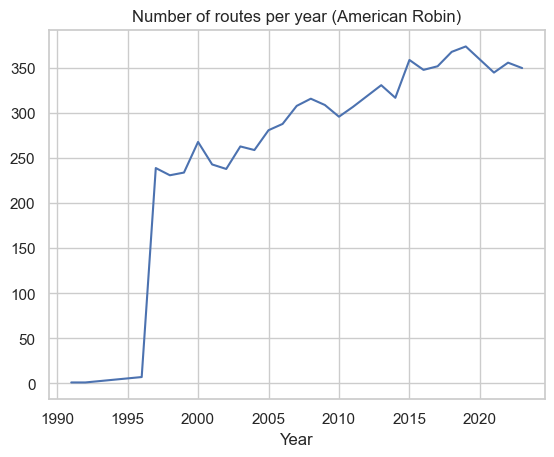

In [ ]:
# Totals[(Totals['RouteDataID']==6346138) & (Totals['AOU']==2060)]['Year']

# spp = 4920 # Piñon Jay
spp = 2060 # 
sppname = 'American Robin'
# spp = 2010 # 
# sppname = 'Black-throated Sparrow'
# spp = 7360
# sppname = 'Carolina Chickadee'
# spp = 4930
# sppname = 'European Starling'
# spp = 4770 #
# sppname = 'Blue Jay'
# spp = 5935 #
# sppname = 'Northern Cardinal'
# spp = 7030 #
# sppname = 'Northern Mockingbird'

# Plot the number of routes per year for the specified species
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
Totals[Totals['AOU']==spp][['Year','ruta']].groupby('Year').count().plot(kind='line', title='Number of routes per year ('+sppname+')',legend=False)



# Totals[Totals['AOU']==4920]

Text(8.194444444444445, 0.5, 'Count of years censed')

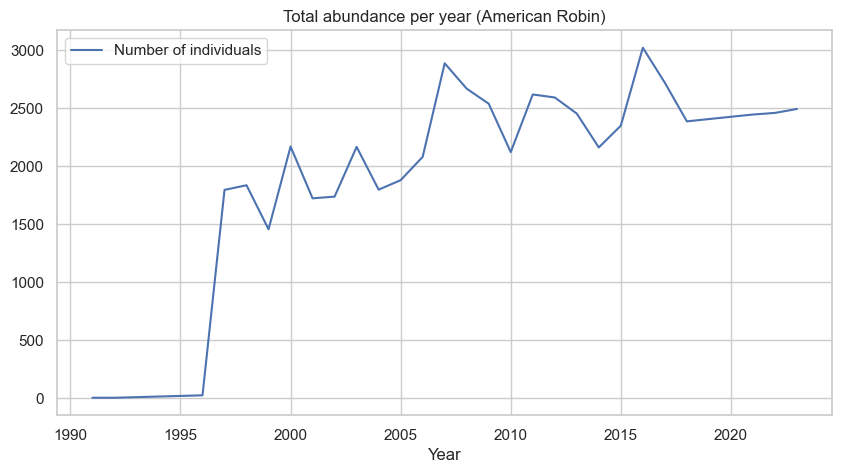

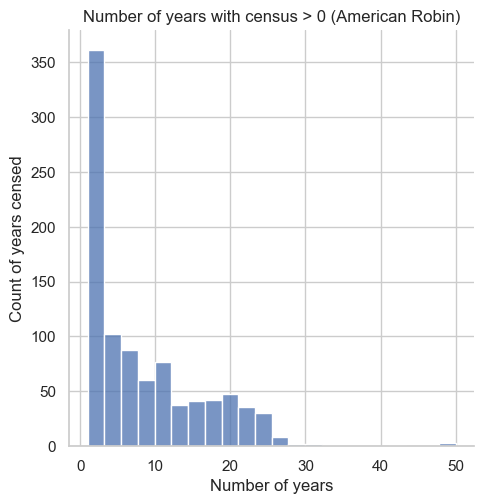

In [ ]:
# Total abundance per year for AOU 4920 (Piñon Jay)
Totals[Totals['AOU']==spp][['Year','Number of individuals']].groupby('Year').sum().plot(kind='line', figsize=(10, 5), title='Total abundance per year ('+sppname+')')


# Number of years with census > 0
sns.displot(Totals[Totals['AOU']==spp][['Year','ruta']].groupby('ruta').count()['Year'])
plt.title('Number of years with census > 0 ('+sppname+')')
plt.xlabel('Number of years')
plt.ylabel('Count of years censed')


### Visualizing  maps

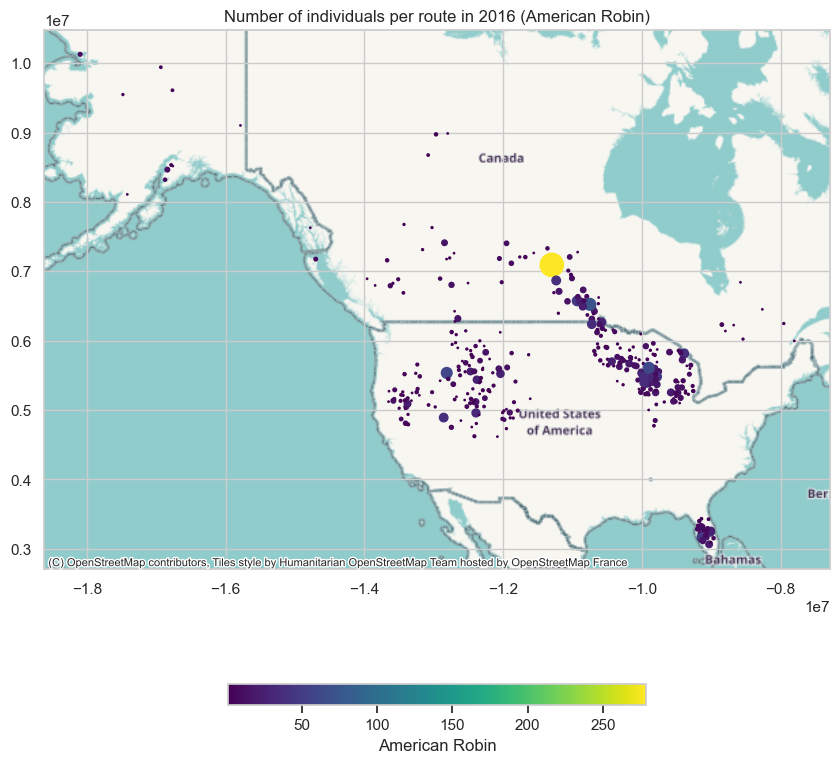

In [ ]:
import geopandas as gpd
import contextily as ctx

yr  = 2016 # Plot the number of individuals per route for the specified species in 2022

subTotals = Totals[Totals['AOU']==spp][['Year','ruta','Longitude','Latitude','Number of individuals']]
# Totals.columns
geototals = gpd.GeoDataFrame(
    subTotals, geometry=gpd.points_from_xy(subTotals.Longitude, subTotals.Latitude), crs="EPSG:4326"
)


geototals = geototals.to_crs(epsg=3857)

# ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax = geototals[geototals['Year']==yr].plot('Number of individuals', cmap='viridis',  markersize='Number of individuals', 
                                             legend=True,
                                             legend_kwds={'shrink': 0.45,'label':sppname,'orientation': 'horizontal'},  # Adjust the shrink value (e.g., 0.5 for 50%)
                                             figsize=(12, 10),
                                             )
# cbar = plt.colorbar(shrink=0.75)
ax.set_title('Number of individuals per route in '+str(yr)+' ('+sppname+')')
ctx.add_basemap(ax)



## Writing data to a dictionary

The dictionary is organized as follows:

- key: (species, routeID)
- value: [(year, abundance)] 

routeID is composed by joining 'Country Number' `Totals['CountryNum'].astype(str)`, 'State Number' `Totals['StateNum'].astype(str)`, and 'Route Number' `Totals['Route'].astype(str)`

In [ ]:
def fill_missing_year_data(
    data_tuples: list[tuple[int, int]],
    start_year: int,
    end_year: int
) -> list[tuple[int, int]]:
    """
    Generates a list of (year, value) tuples for a continuous range of years,
    filling in missing years with a default value of 0.

    Args:
        data_tuples (list[tuple[int, int]]): A list of tuples, where each tuple
                                             is (year, value).
        start_year (int): The first year in the desired continuous range (inclusive).
        end_year (int): The last year in the desired continuous range (inclusive).

    Returns:
        list[tuple[int, int]]: A new list of tuples covering the specified
                               year range, with 0 for years where no data was provided.
                               Returns an empty list if start_year > end_year.
    """
    if not isinstance(data_tuples, list) or not all(isinstance(t, tuple) and len(t) == 2 and isinstance(t[0], int) and isinstance(t[1], int) for t in data_tuples):
        print("Error: 'data_tuples' must be a list of (int, int) tuples.")
        return []
    if not isinstance(start_year, int) or not isinstance(end_year, int):
        print("Error: 'start_year' and 'end_year' must be integers.")
        return []

    if start_year > end_year:
        print(f"Warning: start_year ({start_year}) is greater than end_year ({end_year}). Returning empty list.")
        return []

    # Convert the input list of tuples into a dictionary for faster lookups
    # This maps year -> value
    data_map = {year: value for year, value in data_tuples}

    result_list = []
    # Iterate through the desired year range
    for year in range(start_year, end_year + 1):
        # Check if data exists for the current year
        if year in data_map:
            result_list.append((year, data_map[year]))
        else:
            # If not, append the year with a value of 0
            result_list.append((year, 0))

    return result_list

## TESTING THE FUNCTION ##
# my_data = [(1980, 4), (1968, 20), (1975, 15)]
# first_year = 1966
# last_year = 2024

# print(f"Input data: {my_data}")
# print(f"Desired year range: {first_year}-{last_year}")

# filled_data = fill_missing_year_data(my_data, first_year, last_year)

# filled_data

We will pad the timeseries, starting in 1966 with 0s for those years in which birds were not counted

In [ ]:
first_year = 1966
last_year = 2024

totals_dict = {}

# Group the DataFrame by 'Year' and 'RouteDataID'
# Then iterate through each group
for (spp, route_id), group_df in Totals.groupby(['AOU', 'ruta']):
        # Extract the 'Totals' column for the current group and convert it to a list
        totals_list = list(zip(group_df['Year'].tolist(), group_df['Number of individuals'].tolist()))
        # Add the (spp, route_id) tuple as key and the list of totals as value to the dictionary
        totals_dict[(str(spp), str(route_id))] = fill_missing_year_data(totals_list, first_year, last_year)   #totals_list

We may now extract the data by parsing the dictionary. 

Here are a couple functions that will:

- generate a pandas DataFrame for a given species with routeID as columns and years as rows
- for a given routeID, species as columns and years as rows
- for a given year, species as columns and routes rows

you may then export this to a csv if needed

In [ ]:

def species_to_df(species_id: int, data: dict) -> pd.DataFrame:

    """
    Generates a pandas DataFrame for a given species,
    with routes as columns and years as rows.

    Args:
        species_id (int): The name of the species to filter by.
        data (dict): The input dictionary with (species, route) keys
                     and list of (year, abundance) values.

    Returns:
        pd.DataFrame: A DataFrame with years as index and routes as columns.
                      Returns an empty DataFrame if the species is not found.
    """
    df_data = {}
    years = set()

    for (species, route), abundances in data.items():
        if species == species_id:
            if route not in df_data:
                df_data[route] = {}
            for year, abundance in abundances:
                df_data[route][year] = abundance
                years.add(year)

    if not df_data:
        print(f"No data found for species: {species_name}")
        return pd.DataFrame()

    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(df_data, orient='index').transpose()
    df.index.name = 'Year'
    df.columns.name = 'Route'
    return df.sort_index() # Sort by year    


def route_to_df(route_number: int, data: dict) -> pd.DataFrame:
    """
    Generates a pandas DataFrame for a given route number,
    with species as columns and years as rows.

    Args:
        route_number (int): The route number to filter by.
        data (dict): The input dictionary with (species, route) keys
                     and list of (year, abundance) values.

    Returns:
        pd.DataFrame: A DataFrame with years as index and species as columns.
                      Returns an empty DataFrame if the route is not found.
    """
    df_data = {}
    years = set()

    for (species, route), abundances in data.items():
        if route == route_number:
            if species not in df_data:
                df_data[species] = {}
            for year, abundance in abundances:
                df_data[species][year] = abundance
                years.add(year)

    if not df_data:
        print(f"No data found for route: {route_number}")
        return pd.DataFrame()

    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(df_data, orient='index').transpose()
    df.index.name = 'Year'
    df.columns.name = 'Species'
    return df.sort_index() # Sort by year


def year_to_df(year_value: int, data: dict) -> pd.DataFrame:
    """
    Generates a pandas DataFrame for a given year,
    with species as columns and routes as rows.

    Args:
        year_value (int): The year to filter by.
        data (dict): The input dictionary with (species, route) keys
                     and list of (year, abundance) values.

    Returns:
        pd.DataFrame: A DataFrame with routes as index and species as columns.
                      Returns an empty DataFrame if the year is not found.
    """
    df_data = {}
    routes = set()
    species_set = set()

    for (species, route), abundances in data.items():
        for year, abundance in abundances:
            if year == year_value:
                if route not in df_data:
                    df_data[route] = {}
                df_data[route][species] = abundance
                routes.add(route)
                species_set.add(species)

    if not df_data:
        print(f"No data found for year: {year_value}")
        return pd.DataFrame()

    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(df_data, orient='index')
    df.index.name = 'Route'
    df.columns.name = 'Species'
    return df.sort_index(axis=0).sort_index(axis=1) # Sort by route (rows) and species (columns)


**Examples**

- species: '10'  --Western Grebe (_Aechmophorus,occidentalis_)
- routeID: '1241120'
- year: 2018

In [ ]:
species_to_df('10',totals_dict)

route_to_df('1241120',totals_dict)

year_to_df(2018,totals_dict)



Species,10,100,10210,11,110,1150,1170,1180,1190,12,...,7670,7680,77,770,80,800,8110,860,90,900
Route,,,,,,,,,,,,,,,,,,,,,
124111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1241110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12411101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12411102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1241111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8409293,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8409296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8409297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
